# Zone Temperature Dynamical Model

Goals:
- investigate different physics-informed dynamical models for zone temperature prediction
- thermal dynamics should be captured

In [5]:
from jax import config 
config.update("jax_debug_nans", False)
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

import jax 
import jax.numpy as jnp 
import flax.linen as nn
import optax 
import pandas as pd 

from dynax.core.base_block_state_space import BaseContinuousBlockSSM
from dynax.simulators.simulator import DifferentiableSimulator
from dynax.trainer.train_state import TrainState

## 0. Data and DataLoader
- EP data with prototypical building model
- Real data from Lennox thermostat data

In [6]:
"""
import pandas as pd 

dates = ['01-'+str(i)+'-18' for i in range(14, 28)]
data = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)

combined_data = pd.DataFrame()
for key in data.keys():
    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)

combined_data.to_csv('./data/real-world-data.csv')
"""

"\nimport pandas as pd \n\ndates = ['01-'+str(i)+'-18' for i in range(14, 28)]\ndata = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)\n\ncombined_data = pd.DataFrame()\nfor key in data.keys():\n    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)\n\ncombined_data.to_csv('./data/real-world-data.csv')\n"

In [7]:
data = pd.read_csv('./data/real-world-data.csv')

columns_mapper = {'LocalTime':'time', 'tabtsense0':'temp_zone', 'SP_cool':'csp', 'SP_heat':'hsp', 'CoolDemand':'qcool', 'HeatDemand':'qheat', 'humidityindoor_0':'rh_zone', 'oupresentcompressorfreq':'freq', 'iuairflowrate':'cfm', 'surf_tempf':'temp_out', 'rad':'qsol'}

data = data[columns_mapper.keys()].rename(columns = columns_mapper)
data.index = pd.DatetimeIndex(data['time'], freq='1min')
data = data.drop(columns=['time'])


In [8]:
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol
time,,,,,,,,,,
2018-01-14 18:01:00,69.6,77,70,0,100,35.5,NaN,0,41.531667,0.0
2018-01-14 18:02:00,69.5,77,70,0,100,36.0,NaN,0,41.563333,0.0
2018-01-14 18:03:00,69.5,77,70,0,100,36.0,NaN,0,41.595000,0.0
2018-01-14 18:04:00,69.6,77,70,0,100,36.0,NaN,0,41.626667,0.0
2018-01-14 18:05:00,69.6,77,70,0,100,36.0,NaN,0,41.658333,0.0


This data is from Rohini's house, which has a Lennox thermostat but Carrier unit. Thus the equipment info are basically not available. 
- assume nominal heating capacity is 4 ton (e.g., 14 kW)

In [9]:
# change IP unit to SI
# F to C
data[['temp_zone', 'csp', 'hsp', 'temp_out']] =  5./9*(data[['temp_zone', 'csp', 'hsp', 'temp_out']] - 32)
# W to kW
data['qsol'] /= 1000.
# percentage to kW
data[['qcool', 'qheat']] *= 14./100.

data['qhvac'] = -1*data['qcool'] + data['qheat']

In [10]:
# resampel to 15min 
data = data.resample('15min').mean()
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol,qhvac
time,,,,,,,,,,,
2018-01-14 18:00:00,21.206349,25.0,21.111111,0.0,7.0,35.178571,NaN,0.0,5.409722,0.0,7.0
2018-01-14 18:15:00,21.618519,25.0,21.111111,0.0,0.0,33.733333,NaN,0.0,5.664815,0.0,0.0
2018-01-14 18:30:00,21.329630,25.0,21.111111,0.0,0.0,35.333333,NaN,0.0,5.928704,0.0,0.0
2018-01-14 18:45:00,21.125926,25.0,21.111111,0.0,0.0,36.000000,NaN,0.0,6.192593,0.0,0.0
2018-01-14 19:00:00,21.118519,25.0,21.111111,0.0,0.0,36.333333,NaN,0.0,6.268519,0.0,0.0


In [11]:
# time features
def add_time_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    return data

# use cos and sin to encode cyclical features
def encode_cyclical(data, col, max_val):
    data[col+'_sin'] = np.sin(2*np.pi*data[col]/max_val)
    data[col+'_cos'] = np.cos(2*np.pi*data[col]/max_val)
    return data


In [12]:
target = ["temp_zone"]
outdoor = ["temp_out", "qsol"]
control = ["qhvac"]
feature = target + outdoor + control

data = data[feature]

# add time features
data = add_time_features(data)
data = encode_cyclical(data, "hour", 23)
data = encode_cyclical(data, "dayofweek", 6)
time_feature = ["hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos"]

data = data[feature + time_feature]
data.head()

,temp_zone,temp_out,qsol,qhvac,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
time,,,,,,,,
2018-01-14 18:00:00,21.206349,5.409722,0.0,7.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:15:00,21.618519,5.664815,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:30:00,21.329630,5.928704,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:45:00,21.125926,6.192593,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 19:00:00,21.118519,6.268519,0.0,0.0,-0.887885,0.460065,-2.449294e-16,1.0


## Encoder-Decoder Model

This is a pure data-driven model that predicts the room temperature without ODE format.
$$
T_z|_{t+1}^{t+h} = f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$

### Model

In [13]:
class EncoderDecoder(nn.Module):
    hidden_dim: int = 32
    
    @nn.compact
    def __call__(self, encoder_inputs, decoder_inputs):
        # encoder_inputs: (B, T, Ni)
        # decoder_inputs: (B, T, No)
        # encoder 
        encoder = nn.RNN(
            nn.LSTMCell(features=self.hidden_dim),
            return_carry=True,
            name = "encoder"
        )
        encoder_state, _ = encoder(encoder_inputs)
        # decoder 
        decoder = nn.RNN(
            nn.LSTMCell(features=self.hidden_dim),
            return_carry=False,
            name = "decoder"
        )
        decoder_outputs = decoder(decoder_inputs, initial_carry=encoder_state)

        return decoder_outputs

encoder_decoder = EncoderDecoder(hidden_dim=16)
key = jax.random.PRNGKey(2023)
init_params = encoder_decoder.init(key, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 8)))
out = encoder_decoder.apply(init_params, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 8)))
out.shape

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(4, 12, 16)

In [14]:
# construct a model
class Model(nn.Module):
    hidden_dim: int = 16
    
    @nn.compact
    def __call__(self, encoder_inputs, decoder_inputs, training=True):
        encoder_decoder = EncoderDecoder(hidden_dim=self.hidden_dim)

        out = encoder_decoder(encoder_inputs, decoder_inputs)
        # TODO: dropout rate cannot be propagated, otherwise cannot jit train_step
        out = nn.Dropout(0.2, deterministic=not training)(out)
        #out = nn.BatchNorm(use_running_average=not training)(out)
        #out = nn.Dropout(0.6, deterministic=not training)(out)
        out = nn.Dense(features=1)(out)
        return out

model = Model(hidden_dim=8)
key = jax.random.PRNGKey(2023)
dropout_key = jax.random.PRNGKey(2024)
init_params = model.init(key, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 7)), training=False)
out = model.apply(init_params, jnp.ones((4, 24, 8)), jnp.ones((4, 12, 7)), training=False, rngs={"dropout": dropout_key})
out.shape

(4, 12, 1)

### Data Preparation

In [15]:
# get window data
def get_batch_data_at(batch_index, data_df, n_lags, n_future):
    encoder_inputs = data_df.iloc[batch_index-n_lags:batch_index][encoder_features].values
    decoder_inputs = data_df.iloc[batch_index:batch_index+n_future][decoder_features].values 
    target = data_df.iloc[batch_index:batch_index+n_future][target_col].values

    return encoder_inputs, decoder_inputs, target

# get batched data
def get_batch_data(idx, data_df, n_lags, n_future):
    encoder_inputs = []
    decoder_inputs = []
    targets = []
    for i in idx:
        ei, di, t = get_batch_data_at(i, data_df, n_lags, n_future)
        encoder_inputs.append(ei)
        decoder_inputs.append(di)
        targets.append(t)
    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(targets)

data1 = data.copy()

# data processing parameters
n_lags = 4
n_futures = 1

ratio = 0.75
n_samples = data1.shape[0]
n_train = int(ratio * n_samples)

# get data
encoder_features = time_feature + feature
decoder_features = time_feature + outdoor + control
target_col = target 

# generate training data
batch_index_train = np.arange(n_lags, n_train-n_futures)
encoder_inputs_train, decoder_inputs_train, target_train = get_batch_data(batch_index_train, data1, n_lags, n_futures)

# generate testing data
batch_index_test = np.arange(n_train+n_lags, data1.shape[0]-n_futures)
encoder_inputs_test, decoder_inputs_test, target_test = get_batch_data(batch_index_test, data1, n_lags, n_futures)

In [16]:
encoder_inputs_train.shape, decoder_inputs_train.shape, target_train.shape

((931, 4, 8), (931, 1, 7), (931, 1, 1))

In [17]:
encoder_inputs_test.shape, decoder_inputs_test.shape, target_test.shape

((307, 4, 8), (307, 1, 7), (307, 1, 1))

### Training

In [18]:
# initialize model
model = Model(hidden_dim=8)
dropout_key = jax.random.PRNGKey(2024)
init_params = model.init(key, encoder_inputs_train, decoder_inputs_train, training=False)

# optimizer
schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adamw(1e-3)
)

class MyTrainState(TrainState):
  key: jax.Array

train_state = MyTrainState.create(
    apply_fn=model.apply,
    params=init_params,
    tx = optim,
    key = dropout_key,
)

# inverse simulation train_step
@jax.jit
def train_step(train_state, encoder_inputs, decoder_inputs, target, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=train_state.step)
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(
            params, 
            encoder_inputs, 
            decoder_inputs, 
            training=True, 
            rngs={"dropout": dropout_train_key})
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state


@jax.jit
def test_step(train_state, encoder_inputs, decoder_inputs, target):

    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(
            params, 
            encoder_inputs, 
            decoder_inputs, 
            training=False)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss = mse_loss(train_state.params)

    return loss

In [25]:
n_epochs = 35000

# train loop
steps = []
train_losses = []
test_losses =  []

for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, encoder_inputs_train, decoder_inputs_train, target_train, dropout_key=dropout_key)
    if epoch % 1000 == 0:
        # test 
        test_loss = test_step(train_state, encoder_inputs_test, decoder_inputs_test, target_test)
        print(f"epoch: {epoch},training loss: {loss}, testing loss: {test_loss}")
    
    # save for plotting
    steps.append(epoch)
    train_losses.append(loss)
    test_losses.append(test_loss)


epoch: 0,training loss: 0.03070220723748207, testing loss: 0.4311346411705017
epoch: 1000,training loss: 0.03059571236371994, testing loss: 0.440106600522995
epoch: 2000,training loss: 0.039564136415719986, testing loss: 0.4428834915161133
epoch: 3000,training loss: 0.035576190799474716, testing loss: 0.4462944567203522
epoch: 4000,training loss: 0.03104288876056671, testing loss: 0.4521297812461853
epoch: 5000,training loss: 0.03312860056757927, testing loss: 0.4572482407093048
epoch: 6000,training loss: 0.043755609542131424, testing loss: 0.47636526823043823
epoch: 7000,training loss: 0.027797870337963104, testing loss: 0.486107736825943
epoch: 8000,training loss: 0.028531799092888832, testing loss: 0.5002091526985168
epoch: 9000,training loss: 0.02976301498711109, testing loss: 0.49355196952819824
epoch: 10000,training loss: 0.034120384603738785, testing loss: 0.48234954476356506
epoch: 11000,training loss: 0.03111741878092289, testing loss: 0.4943754971027374
epoch: 12000,training 

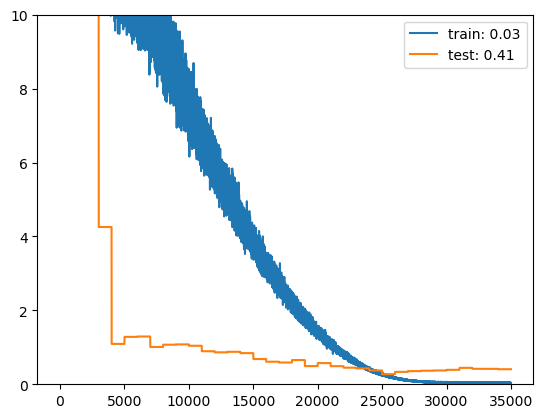

In [20]:
# plot loss
result_folder = f'./models/m1-encoder-decoder/ph={n_futures}/'
plt.figure()
plt.plot(steps, train_losses, label=f"train: {train_losses[-1]:.2f}")
plt.plot(steps, test_losses, label=f"test: {test_losses[-1]:.2f}")
plt.ylim([0, 10])
plt.legend()
plt.savefig(result_folder + "loss.png")

In [21]:
# for plots
y_pred_train = model.apply(train_state.params, encoder_inputs_train, decoder_inputs_train, training=False)
y_pred_test = model.apply(train_state.params, encoder_inputs_test, decoder_inputs_test, training=False)
y_pred_train.shape, y_pred_test.shape

((931, 1, 1), (307, 1, 1))

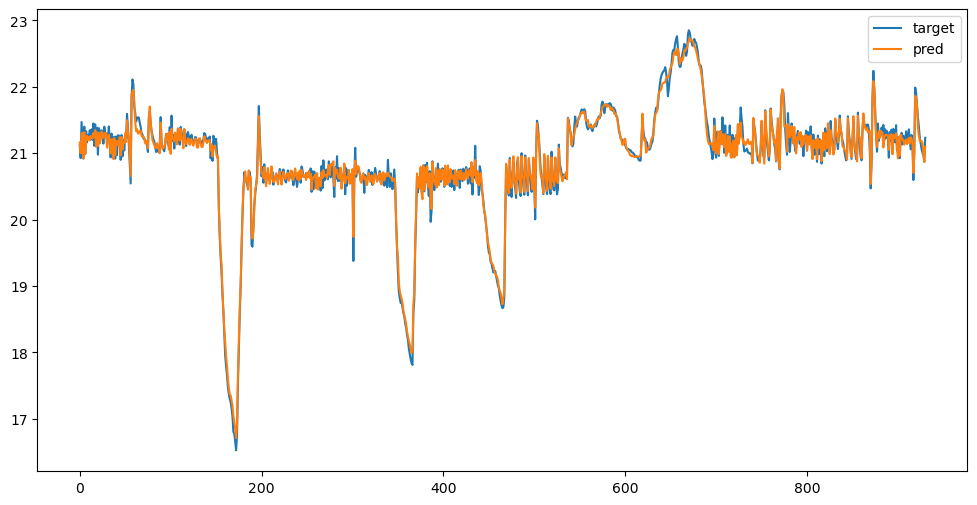

In [22]:

# just plot one step
plt.figure(figsize=(12,6))
plt.plot(target_train[:,0], label='target')
plt.plot(y_pred_train[:,0], label='pred')
plt.legend()

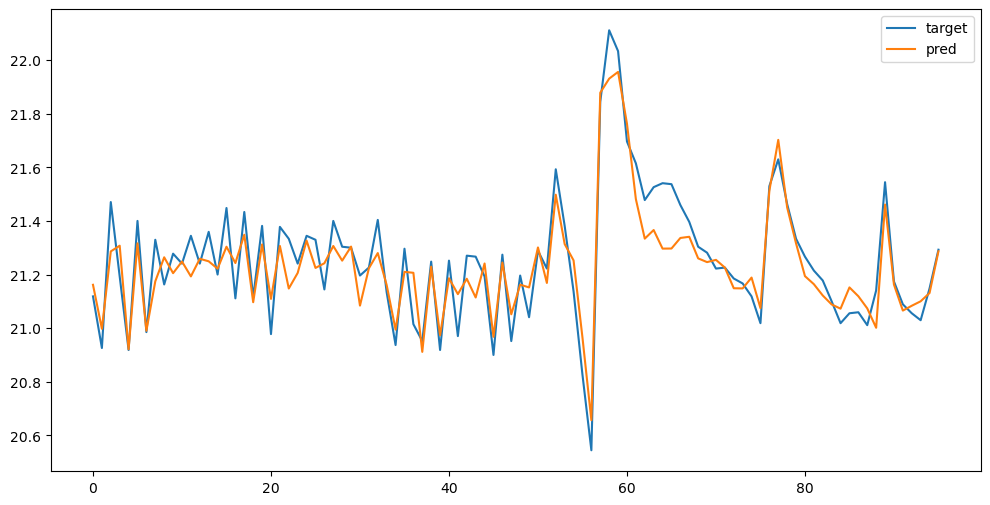

In [23]:
plt.figure(figsize=(12,6))
plt.plot(target_train[:,0][:24*4], label='target')
plt.plot(y_pred_train[:,0][:24*4], label='pred')
plt.legend()

In [24]:
plt.figure(figsize=(12,6))
plt.plot(target_train[:,1][:24*4], label='target')
plt.plot(y_pred_train[:,1][:24*4], label='pred')
plt.legend()

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 1200x600 with 0 Axes>

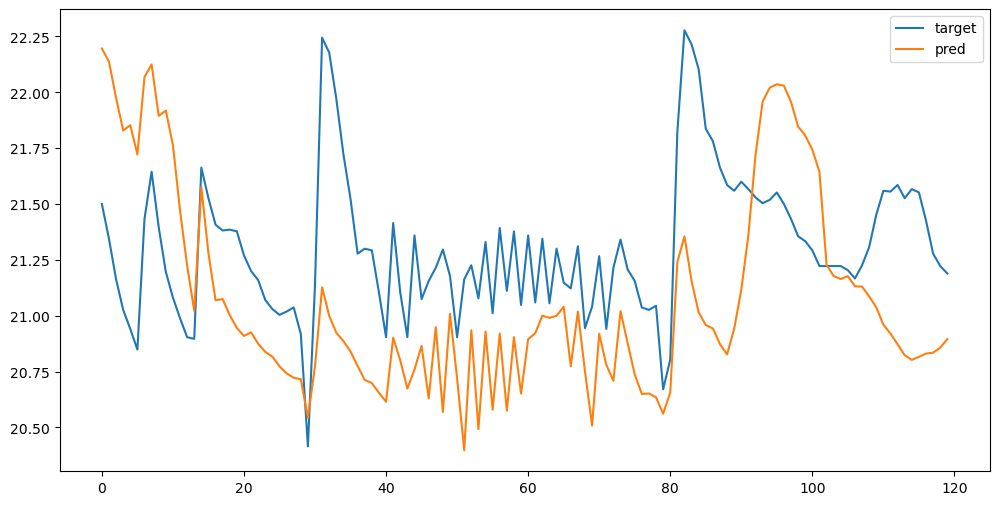

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(target_test[:,7], label='target')
plt.plot(y_pred_test[:,7], label='pred')
plt.legend()

### Result Analysis

Physics-consistent


In [ ]:
# make up some samples
encoder_sample = encoder_inputs_train[[100], :, :] # (T, Ni)
decoder_sample = decoder_inputs_train[[100], :, :] # (T, No)

In [ ]:
q_hvac = np.array([i for i in range(-10, 10)])
q_hvac_decoder = np.tile(q_hvac[:, np.newaxis, np.newaxis], reps=(1, n_futures, 1)) # (B, T, 1)
n_points = q_hvac_decoder.shape[0]
q_hvac_decoder.shape

(20, 96, 1)

In [ ]:
# combine faked control inputs with previous sample features
other_decoder = np.tile(decoder_sample[:, :, :-1], reps=(n_points, 1, 1))
decoder_inputs = np.concatenate([other_decoder, q_hvac_decoder], axis=-1)
encoder_inputs = np.tile(encoder_sample, reps=(n_points, 1, 1))


In [ ]:
# apply models
y_pred = model.apply(train_state.params, encoder_inputs, decoder_inputs, training=False)

# current temperature
curr_temp_zone = encoder_sample[0, -1, -4]

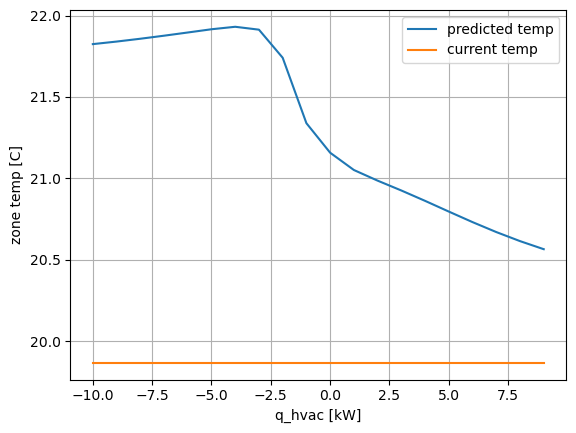

In [ ]:
plt.figure()
plt.plot(q_hvac.squeeze(), y_pred[:, 0], label='predicted temp') #
plt.plot(q_hvac.squeeze(), [curr_temp_zone]*n_points, label='current temp') # previous temperature
plt.legend()
plt.grid()
plt.xlabel('q_hvac [kW]')
plt.ylabel('zone temp [C]')
plt.savefig(result_folder + "physics-consistency.png")